# Age Estimation and Gender Classification

In this assignment, you will train CNN models to estimate a person's age and gender by given a face image. Please read carefully all the instructions before you start to write your code.

**Your tasks**

You need train two CNN models:
- one is defined by you with a few restrictions and be trained from scratch, save it as `age_gender_A.h5`
- the other is to finetune a pretrained model, save it as `age_gender_B.h5`

**Dataset**

Your models will be trained and validated on a folder `train_val/` containing 5,000 labeled face images (size: 128 x 128), originated from the UTKFace dataset. During marking, your code will be tested on unseen test data.

**Performance metric**

The metrics for measuring the performance on the test set are:
- age estimation: MAE (Mean Absolute Error)
- gender classification: accuracy

**Please use the GPU time wisely.**

Just be aware that there is some limit of free GPU usage (It is said the users can use up to 12 hours in row. But many people found they reached its limit far less than 12 hours.). Therefore, I would give you three suggestions to mimimise the risk of reaching the limit.

1. Make sure you have a stable internet connection.
2. Double check all the hyperparameters are good before you start to train the model.
3. According to my experience, each model should be trained in less than 2 hours. If much longer than that, you'd better consider adjusting the architecture.

## Setting Up: Mount the google drive
Mount your google drive to the notebook.

Also don't forget to **enable GPU** before your training.


In [20]:
# Import modules
import random
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.image import imread
import cv2
from keras.preprocessing.image import ImageDataGenerator, random_rotation
from keras.models import Sequential,load_model,Model
from keras.layers import Conv2D,MaxPool2D,Dense,Dropout,BatchNormalization,Flatten,Input
from keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dropout, Dense, concatenate
from keras.layers import RandomBrightness, RandomContrast, RandomCrop, RandomFlip, RandomRotation, RandomZoom
from keras.utils import plot_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, auc, roc_curve

# Mounting google drive to notebook
from google.colab import drive
import tensorflow as tf

drive.mount('/content/drive')
tf.config.list_physical_devices('GPU')

# Path to the folder containing images
folder = '/content/drive/My Drive/ML2_CW1/train_val'

# Path to model folder for saving model
your_model_folder = '/content/drive/My Drive/ML2_CW1/models/'

# Set random seed
random.seed(10)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Visualize a few photos
It is always benificial to know your data well before you start. Here display a few (at least 20) images together with its corresponding age and gender from the `train_val/` folder to have a first impression of the dataset. You may also check what the size of the images are.

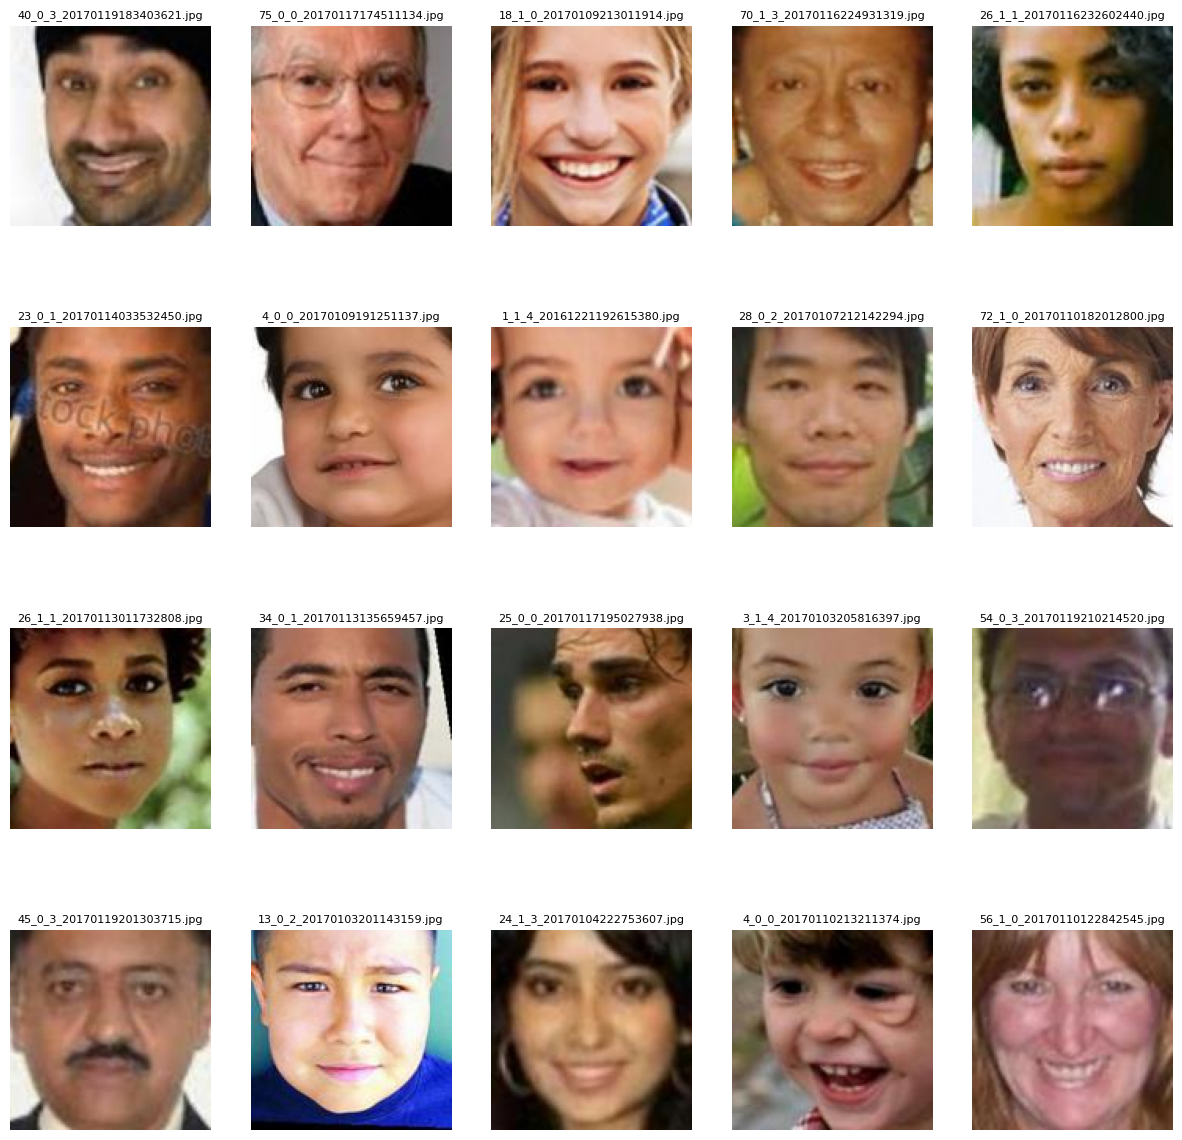

In [2]:
# Display 20 images
# Get a list of the first 20 images in folder
image_files = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]

# Plot images
plt.figure(figsize=(15, 15))
for i, image_file in enumerate(image_files[:20]):
    plt.subplot(4, 5, i+1)
    image_path = os.path.join(folder, image_file)
    image = imread(image_path)
    plt.imshow(image)
    plt.title(image_file[:-9], fontsize=8) # Crop the image title
    plt.axis('off')

plt.show()


## Rearrange the dataset
You may do any arrangement for the dataset to suit your later process, such as splitting into training set and validation set, saving the gender labels and age some how, and so on.


In [12]:
# Split the dataset to training set, validation set and test set and save as dataframe for generator input
# Test set can be optionally set to zero.

def split_data_and_save_df(directory, val_share=0.15, test_share=0.0):
  """
  Split the items in image_files into training, validation, and test sets,
  and save them into dataframe format to be input to data generator.

  Inputs:
  - image_files: List of file paths.
  - val_share: Proportion of samples for the validation set (0 to 1).
  - test_share: Proportion of samples for the test set (0 to 1).
  """

  # Shuffle the image_files list
  all_files = os.listdir(folder)
  random.shuffle(all_files)

  # Calculate the number of samples for each set
  num_samples = len(all_files)
  num_val = int(val_share * num_samples)
  num_test = int(test_share * num_samples)
  num_train = num_samples - num_val - num_test

  # get a 3 lists of filenames for train, val and test set
  train_filenames = all_files[: num_train]
  val_filenames = all_files[num_train : (num_train + num_val)]
  if test_share != 0.0:
    test_filenames = all_files[(num_train + num_val) : ]

  def create_dataframe(filelist):
    """
    Takes in a list of image filenames and returns a pandas dataframe with columns
    'directory': Full directory of each image
    'age': Age of face shown in the image
    'gender': Gender of face shown in the image

    """
    # Initialise empty list to save data
    df_data = []

    # Loop through every file in input filelist and extract filepath, age and gender
    for file in filelist:
      filepath = os.path.join(directory, file)
      age = int(file.split('_')[0])
      gender = int(file.split('_')[1])
      # Append image info to initialised list
      df_data.append({'directory': filepath, 'age': age, 'gender': gender})

    # return data in dataframe form
    return pd.DataFrame(df_data)

  # Create dataframes and return as output
  train_df = create_dataframe(train_filenames)
  val_df = create_dataframe(val_filenames)

  if test_share > 0.0:
    test_df = create_dataframe(test_filenames)
    # Return 3 dataframes if test_share > 0
    print(f'''
      Shape of training set dataframe: {train_df.shape};
      Shape of validation set dataframe: {val_df.shape};
      Shape of test set dataframe: {test_df.shape};
      ''')
    return train_df, val_df, test_df
  else:
    # Else return two dataframes for train and val and None
    print(f'''
          Shape of training set dataframe: {train_df.shape};
          Shape of validation set dataframe: {val_df.shape};
          test_df is a None object as test_share = 0.0.
          ''')
    return train_df, val_df, None

# Run function to produce dataframes to input into image data generator
train_df, val_df, test_df = split_data_and_save_df(folder, val_share=0.12, test_share=0.1)

# Inspect output
train_df.head()


      Shape of training set dataframe: (3900, 3);
      Shape of validation set dataframe: (600, 3);
      Shape of test set dataframe: (500, 3);
      


,directory,age,gender
0,/content/drive/My Drive/ML2_CW1/train_val/46_1...,46,1
1,/content/drive/My Drive/ML2_CW1/train_val/67_1...,67,1
2,/content/drive/My Drive/ML2_CW1/train_val/14_0...,14,0
3,/content/drive/My Drive/ML2_CW1/train_val/24_1...,24,1
4,/content/drive/My Drive/ML2_CW1/train_val/32_0...,32,0


## STEP1: Data pre-processing
Now you need do some pre-processing before feeding data into a CNN network. You may consider:

1.	Rescale the pixel values (integers between 0 and 255) to [0,1]. **You must do this rescaling.** Otherwise the testing performance will be affected significantly, as the test images will be rescaling in this way.
2.	Data augmentation.

**Don't rescale the age to [0,1].** Otherwise the testing performance will be affected significantly, as the original age is used in the testing stage.

### Data Split (Performed in Previou step) and Augmentation
#### Data Rescaling and Augmentation using ImageDataGenerator

Found 3900 validated image filenames.
Found 600 validated image filenames.
Found 500 validated image filenames.


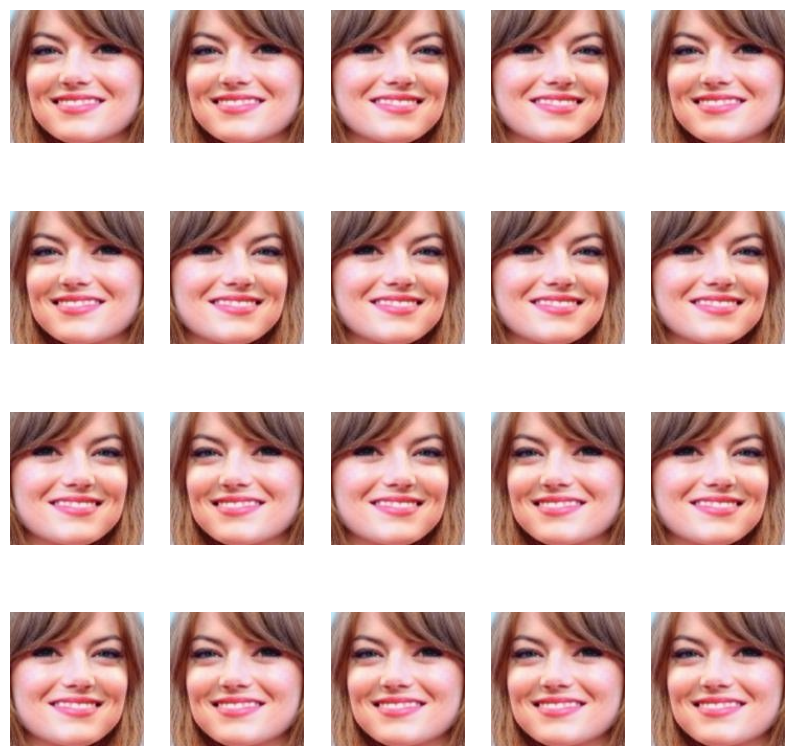

In [14]:
# DATA SPLIT IS PERFORMED IN PREVIOUS STEP

# Define parameters for ImageDataGenerator
batch_size = 32

# Create instances of ImageDataGenerator for train/val/test data
train_datagen = ImageDataGenerator(
                rescale=1./255,
                horizontal_flip = True,
                fill_mode = 'nearest')

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create a generator for training data
train_generator = train_datagen.flow_from_dataframe(
                  train_df,
                  x_col='directory',
                  y_col=['age','gender'],
                  target_size=(128, 128),
                  batch_size=batch_size,
                  class_mode='multi_output')

# Create a generator for validation data
val_generator = val_datagen.flow_from_dataframe(
                val_df,
                x_col='directory',
                y_col=['age','gender'],
                target_size=(128, 128),
                batch_size=batch_size,
                class_mode='multi_output')

# Create a generator for test data
if isinstance(test_df, pd.DataFrame):
  test_generator = test_datagen.flow_from_dataframe(
                    test_df,
                    x_col='directory',
                    y_col=['age','gender'],
                    target_size=(128, 128),
                    batch_size=batch_size,
                    class_mode='multi_output')

# Visualise augmented images
from keras.preprocessing import image
import matplotlib.pyplot as plt

fnames = train_df.directory.to_list()
img_path = fnames[11]
img = image.load_img(img_path, target_size=(128,128))
x = image.img_to_array(img)
x = x.reshape((1,)+x.shape)
i = 0
plt.figure(figsize=(10,10))
for batch in train_datagen.flow(x,batch_size=1):
  plt.subplot(4, 5,i+1)
  plt.axis("off")
  imgplot = plt.imshow(image.array_to_img(batch[0]))
  i += 1
  if i%20 == 0:
    break
plt.show()

## STEP2A: Build your own CNN network
Define your own CNN for classifying the gender and predicting the age. Though there are two tasks, you need **only one CNN model, but with two outputs** - you may search online for solution.

There are a few restrictions about your network as follows.
1.	The input size must be 128 x 128 x 3, which means you **should not resize** the original images. This is because my test code relies on this particular input size. Any other size will cause problem in the testing stage.
2.  Please treat the gender classification as a binary problem, i.e., **the output layer for the gender branch has only 1 unit**, instead of 2 (though it is correct to treat the gender classification as a mutli-class problem where class number is 2, the last layer has 2 units). This is because my test code only works for the 1-unit-last-layer gender branch setting.
3.	The size of feature maps being fed to the first fully connected layer must be less than 10 x 10, while there is no number limitation about the depth.
4.	You may choose any techniques for preventing overfitting.

In the end of the cell, use `modelA.summary()` to output the model architecture. You may also use `plot_model()` to visualize its architecture.

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d_36 (Conv2D)          (None, 128, 128, 32)         2432      ['input_10[0][0]']            
                                                                                                  
 batch_normalization_36 (Ba  (None, 128, 128, 32)         128       ['conv2d_36[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 max_pooling2d_36 (MaxPooli  (None, 64, 64, 32)           0         ['batch_normalization_36

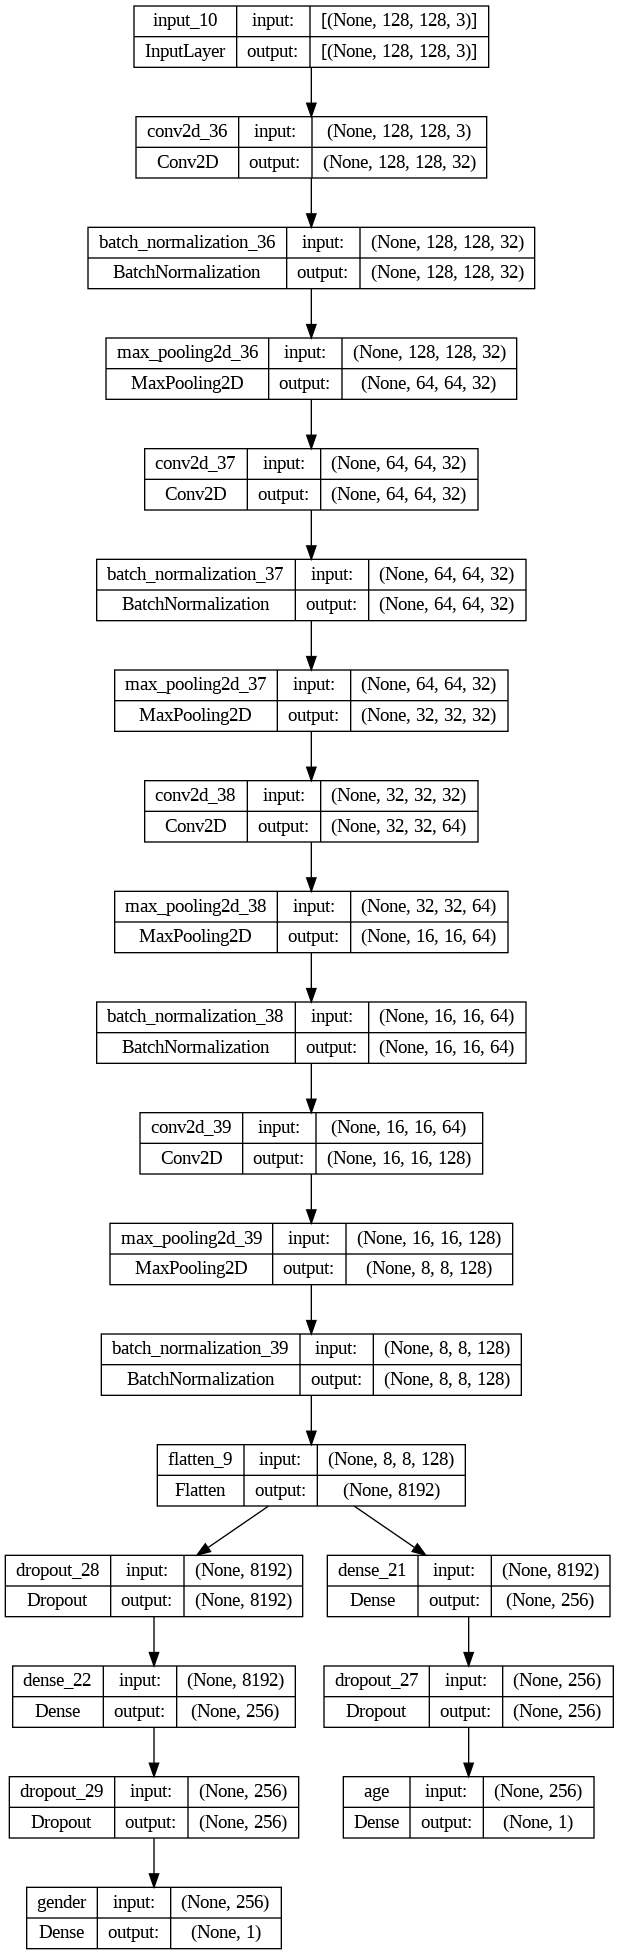

In [ ]:
from keras.layers import Conv2D,MaxPooling2D, Dense,Dropout,BatchNormalization,Flatten,Input

# Define Input Layer
input_layer = Input(shape=(128, 128, 3))

# Shared convolutional layers
shared_conv = Conv2D(32, kernel_size=5, padding='same', activation='relu')(input_layer)
shared_conv = BatchNormalization()(shared_conv)
shared_conv = MaxPooling2D((2, 2), strides=2)(shared_conv)
shared_conv = Conv2D(32, kernel_size=5, padding='same', activation='relu')(shared_conv)
shared_conv = BatchNormalization()(shared_conv)
shared_conv = MaxPooling2D((2, 2), strides=2)(shared_conv)
shared_conv = Conv2D(64, kernel_size=3, padding='same', activation='relu')(shared_conv)
shared_conv = MaxPooling2D((2, 2), strides=2)(shared_conv)
shared_conv = BatchNormalization()(shared_conv)
shared_conv = Conv2D(128, kernel_size=3, padding='same', activation='relu')(shared_conv)
shared_conv = MaxPooling2D((2, 2), strides=2)(shared_conv)
shared_conv = BatchNormalization()(shared_conv)

# Flatten
flatten = Flatten()(shared_conv)

# Age branch
age_branch_A = Dense(256, activation='relu')(flatten)
age_branch_A = Dropout(0.2)(age_branch_A)
age_branch_A = Dense(1, activation='relu', name='age')(age_branch_A)


# Gender branch
gender_branch_A = Dropout(0.5)(flatten)
gender_branch_A = Dense(256, activation='relu')(gender_branch_A)
gender_branch_A = Dropout(0.5)(gender_branch_A)
gender_branch_A = Dense(1, activation='sigmoid', name='gender')(gender_branch_A)

# Combine both branches
modelA = Model(inputs=input_layer, outputs=[age_branch_A, gender_branch_A])

# Print model summary and plot model
modelA.summary()
plot_model(modelA, show_shapes=True)


## STEP3A: Compile and train your model
Compile and train your model here.
Save your model by `modelA.save(your_model_folder+"age_gender_A.h5")` after training.

**DON'T use any other name for your model file.** This is because my test code relies on this particular model name. Any other file name will cause problem in the testing stage.

**Save the model with `save()` instead of `save_weights()`.** This is because I will load the model by

`modelA = load_model(model_folder+"age_gender_A.h5")`.


In [ ]:
# Optimiser and callback
from keras.optimizers.legacy import Adam, SGD
# from keras.optimizers.schedules import ExponentialDecay
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Adam Optimiser
opt_adam_A = Adam()

# Callback
my_callbacks_A = [EarlyStopping(patience=8,
                              monitor='val_loss',
                              mode='min',
                              min_delta=0.5,
                              verbose=1,
                              restore_best_weights=True)]

# Compile the model
modelA.compile(optimizer=opt_adam_A,
               loss={'age': 'mse', 'gender': 'binary_crossentropy'},
               metrics={'age': 'mae', 'gender': 'accuracy'})

# Train the model using fit_generator
history_A = modelA.fit(train_generator,
                        epochs=300,
                        callbacks=my_callbacks_A,
                        validation_data=val_generator)

Epoch 1/300
138/138 [==============================] - 15s 98ms/step - loss: 283.4653 - age_loss: 282.6439 - gender_loss: 0.8213 - age_mae: 12.6435 - gender_accuracy: 0.6916 - val_loss: 812.4095 - val_age_loss: 811.2477 - val_gender_loss: 1.1617 - val_age_mae: 22.4317 - val_gender_accuracy: 0.5417
Epoch 2/300
138/138 [==============================] - 13s 94ms/step - loss: 166.0737 - age_loss: 165.5907 - gender_loss: 0.4830 - age_mae: 9.6258 - gender_accuracy: 0.7759 - val_loss: 558.0166 - val_age_loss: 557.3981 - val_gender_loss: 0.6184 - val_age_mae: 17.7770 - val_gender_accuracy: 0.7400
Epoch 3/300
138/138 [==============================] - 13s 95ms/step - loss: 132.9930 - age_loss: 132.5623 - gender_loss: 0.4307 - age_mae: 8.6281 - gender_accuracy: 0.8039 - val_loss: 524.8674 - val_age_loss: 524.4673 - val_gender_loss: 0.4002 - val_age_mae: 17.8941 - val_gender_accuracy: 0.8400
Epoch 4/300
138/138 [==============================] - 13s 94ms/step - loss: 111.2392 - age_loss: 110.856

## Save trained model
**MODELS ARE INITIALLY SAVED WITH TIMESTAMPS TO FACILITATE IDENTIFICATION**

In [ ]:
from datetime import datetime

# Get the current date and time and format to mm_dd_hh_mm
formatted_date_time = datetime.now().strftime("%m_%d_%H_%M")

# Save modelA to local path on Google drive
modelA.save(f"{your_model_folder}/age_gender_A_{formatted_date_time}.h5")

## Load trained model

In [ ]:
modelA = load_model(your_model_folder+"age_gender_A.h5")

## STEP4A: Draw the learning curves
Draw four figures as follows
1.	The loss of the gender classification over the training and validation set
2.	The accuracy of the gender classification over the training and validation set
3.	The loss of the age estimation over the training and validation set
4.	The MAE of the age estimation over the training and validation set


In [58]:
def plot_training_curves(history):
  '''
  Takes as input model training history.
  Plots 4 learning curves.
  '''
  # Get number of training epochs
# epochs = range(len(history.history['gender_accuracy']))

  # Plot gender training and validation accuracy
  plt.plot(history.history['gender_accuracy'], 'b', label='Training Accuracy')
  plt.plot(history.history['val_gender_accuracy'], 'r', label='Validation Accuracy')
  plt.title('Gender Classification Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.grid(True, alpha=0.5)
  plt.legend()
  plt.show()

  # Plot gender training and validation loss
  plt.plot(history.history['gender_loss'], 'b', label='Training Loss')
  plt.plot(history.history['val_gender_loss'], 'r', label='Validation Loss')
  plt.title('Gender Classification Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.grid(True, alpha=0.5)
  plt.legend()
  plt.show()

  # Plot age training and validation MAE
  plt.plot(history.history['age_mae'], 'b', label='Training MAE')
  plt.plot(history.history['val_age_mae'], 'r', label='Validation MAE')
  plt.title('Age Prediction MAE')
  plt.xlabel('Epochs')
  plt.ylabel('MAE')
  plt.grid(True, alpha=0.5)
  plt.legend()
  plt.show()

  # Plot age training and validation loss
  plt.plot(history.history['age_loss'], 'b', label='Training Loss')
  plt.plot(history.history['val_age_loss'], 'r', label='Validation Loss')
  plt.title('Age Prediction Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.grid(True, alpha=0.5)
  plt.legend()
  plt.show()

  return

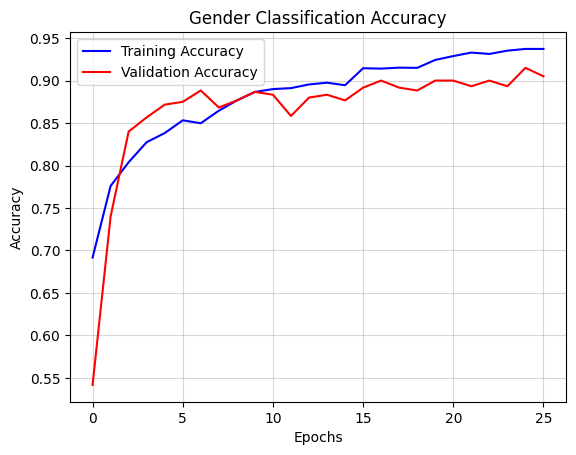

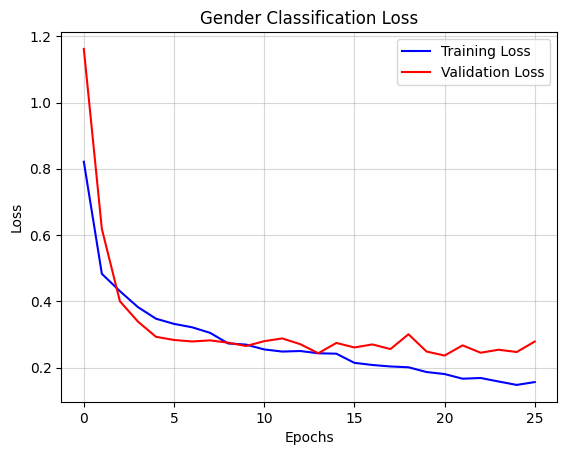

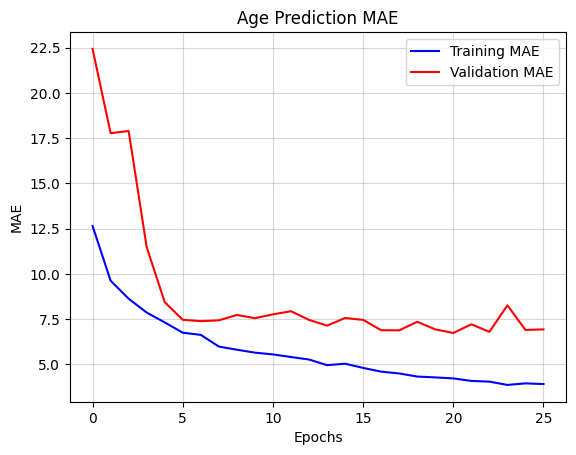

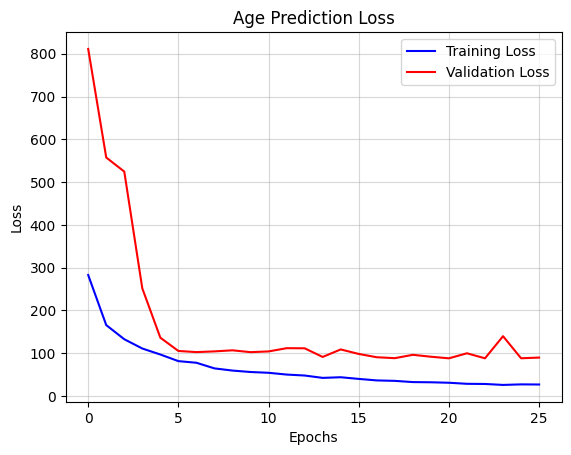

In [ ]:
# Plot training curves for model A
plot_training_curves(history_A)

## STEP2B: Build a CNN network based on a pre-trained model
Choose one existing CNN architecture pre-trained on ImageNet, and fine-tune on this dataset.

The same as required in Model A, **don’t resize the input image size**. **The output layer for the gender branch is set to have only 1 unit**.

In the end of the cell, use `modelB.summary()` to output the model architecture. You may also use `plot_model()` to visualize its architecture.


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_34 (InputLayer)       [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

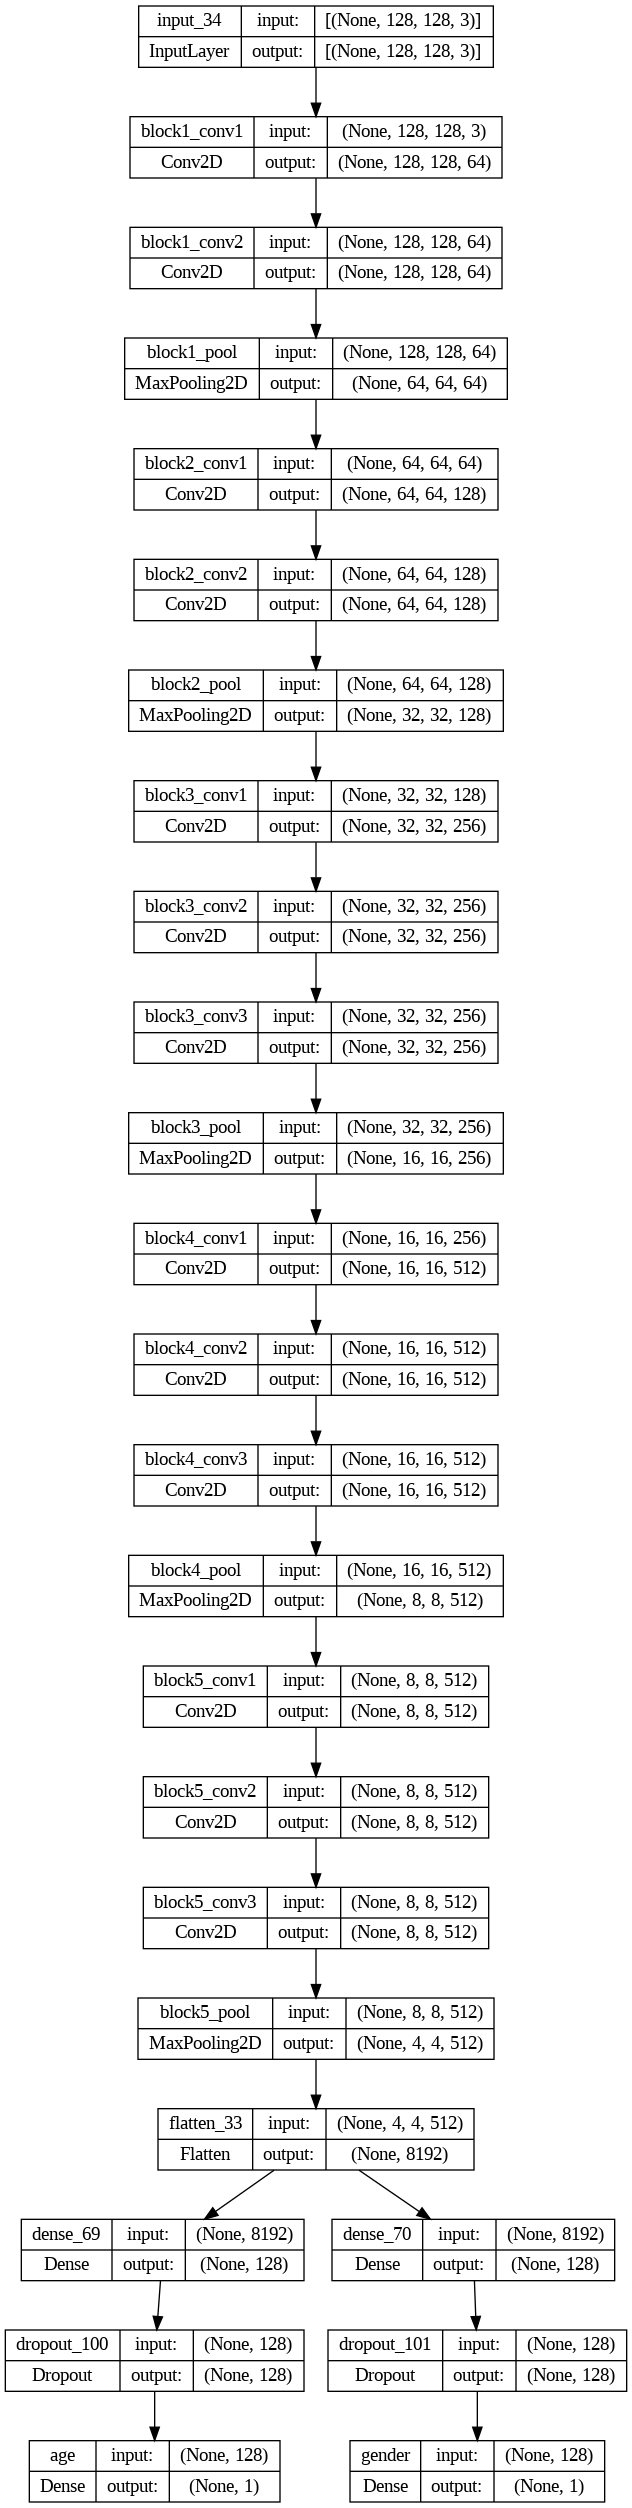

In [88]:
from keras.regularizers import l2
from keras.applications import VGG16

# build the convolutional base of VGG16 network
VGG16_conv_base = VGG16(weights = 'imagenet', # the model if pre-trained on ImageNet
                  include_top = False, # do not include the FC layers
                  input_shape = (128,128,3))

# Freeze the first 14 layers (convolutional blocks 1-4)
for layer in VGG16_conv_base.layers[:14]:
    layer.trainable = False

VGG16_conv_base.summary()

# Build a classifier to put on top of the convolutional model

# Flatten
flatten = Flatten()(VGG16_conv_base.output)

# Age
age_branch_B = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(flatten)
age_branch_B = Dropout(0.4)(age_branch_B)
age_branch_B = Dense(1, activation='relu', name='age')(age_branch_B)

# Gender branch

gender_branch_B = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(flatten)
gender_branch_B = Dropout(0.4)(gender_branch_B)
gender_branch_B = Dense(1, activation='sigmoid', name='gender')(gender_branch_B)

# Combine both branches
modelB = Model(inputs=VGG16_conv_base.input, outputs=[age_branch_B, gender_branch_B])

modelB.summary()
from keras.utils import plot_model
plot_model(modelB, show_shapes=True)

## STEP3B: Compile and train your model
Compile and train your model here.
Save your model to `age_gender_B.h5` after training.

**DON'T use any other name for your model file.** This is because my test code relies on this particular model name. Any other file name will cause problem in the testing stage.

**Also, save the model with `save()` instead of `save_weights()`.**


In [89]:
# Optimiser and callback
from keras.optimizers.legacy import Adam, SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Adam Optimiser
opt_adam_B = Adam(learning_rate=0.00001)

# Callback
my_callbacks_B = [EarlyStopping(patience=8,
                              monitor='val_loss',
                              mode='min',
                              min_delta=0.5,
                              verbose=1,
                              restore_best_weights=True)]
# Compile the model
modelB.compile(optimizer=opt_adam_B,
               loss={'age': 'mse', 'gender': 'binary_crossentropy'},
               metrics={'age': 'mae', 'gender': 'accuracy'})

# Fit model
history_B = modelB.fit(train_generator,
                        epochs=300,
                        batch_size=32,
                        callbacks=my_callbacks_B,
                        validation_data=val_generator)


Epoch 1/300
138/138 [==============================] - 15s 104ms/step - loss: 528.5215 - age_loss: 522.8808 - gender_loss: 0.7330 - age_mae: 17.4120 - gender_accuracy: 0.5902 - val_loss: 229.3277 - val_age_loss: 223.9734 - val_gender_loss: 0.5591 - val_age_mae: 11.5353 - val_gender_accuracy: 0.7150
Epoch 2/300
138/138 [==============================] - 14s 101ms/step - loss: 208.5415 - age_loss: 203.2680 - gender_loss: 0.5699 - age_mae: 11.0684 - gender_accuracy: 0.7109 - val_loss: 175.4088 - val_age_loss: 170.3261 - val_gender_loss: 0.4651 - val_age_mae: 9.9345 - val_gender_accuracy: 0.7917
Epoch 3/300
138/138 [==============================] - 14s 99ms/step - loss: 166.9738 - age_loss: 161.9121 - gender_loss: 0.5185 - age_mae: 9.7783 - gender_accuracy: 0.7509 - val_loss: 157.7720 - val_age_loss: 152.8704 - val_gender_loss: 0.4304 - val_age_mae: 9.1738 - val_gender_accuracy: 0.8000
Epoch 4/300
138/138 [==============================] - 14s 101ms/step - loss: 151.9249 - age_loss: 147.0

## Save trained model
**MODELS ARE INITIALLY SAVED WITH TIMESTAMPS TO FACILITATE IDENTIFICATION**

In [92]:
from datetime import datetime

# Get the current date and time and format to mm_dd_hh_mm
formatted_date_time = datetime.now().strftime("%m_%d_%H_%M")

# Save modelA to local path on Google drive
modelB.save(f"{your_model_folder}/age_gender_B_{formatted_date_time}.h5")

## Load trained model


In [ ]:
modelB = load_model(your_model_folder+"age_gender_B.h5")

## STEP4B: Draw the learning curve
Draw four figures as follows
1.	The loss of the gender classification over the training and validation set
2.	The accuracy of the gender classification over the training and validation set
3.	The loss of the age estimation over the training and validation set
4.	The MAE of the age estimation over the training and validation set

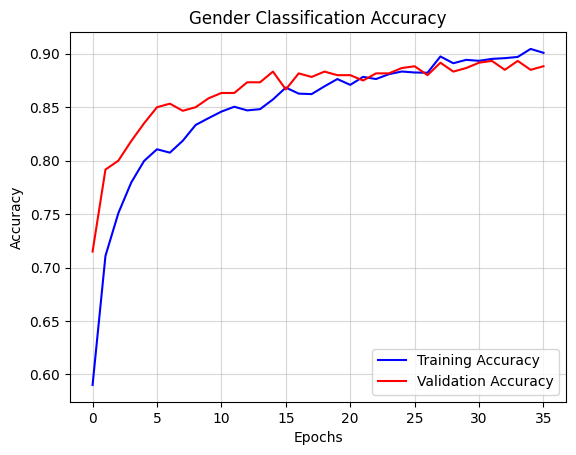

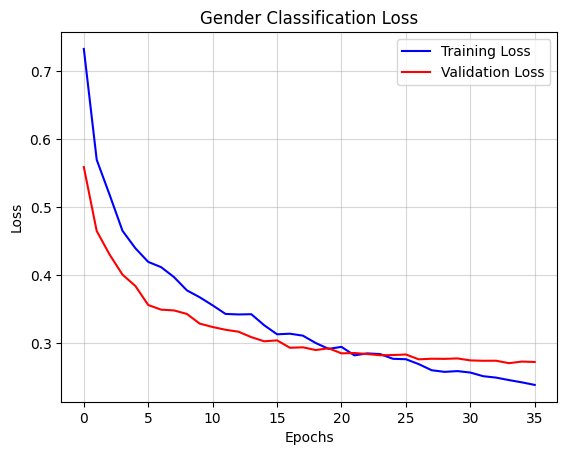

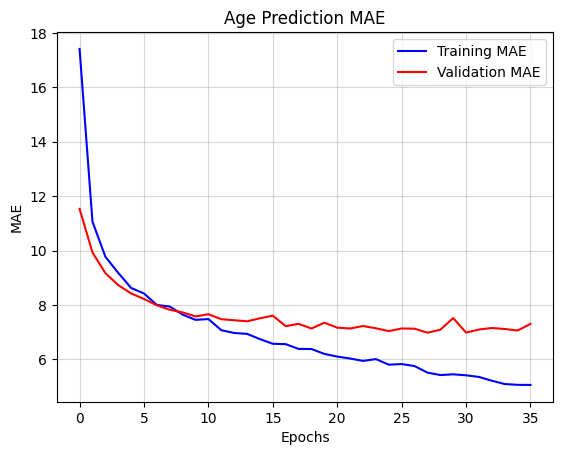

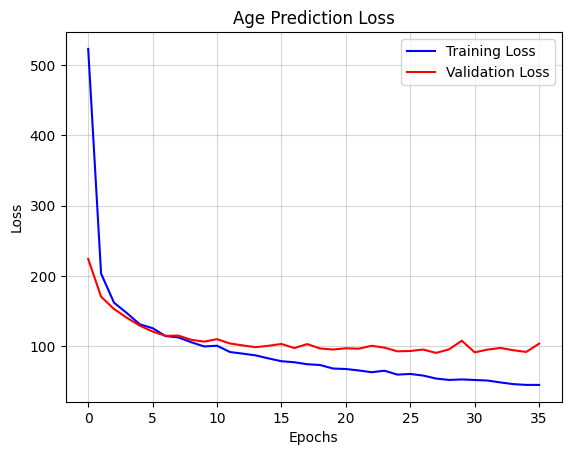

In [91]:
# Plot training curves for model A
plot_training_curves(history_B)

## STEP5: Evaluate the model on the test set
I will add my test code here to test the two models you trained. The test set will not be available before your submission.

The metrics for measuring the performance on the test set are:
- age estimation: MAE (Mean Absolute Error)
- gender classification: accuracy


In [ ]:
#
# Don't add code in this cell when submitting this file
#